# ASTR 21100 

# "Computational Techniques in Astrophysics"

## Instructor: Andrey Kravtsov

### office: ERC 415; email: kravtsov@uchicago.edu
### office hours: Tue, 10:30am-noon (unless noted otherwise)

#### Teaching Assistants: 
#### Dimitrios Tanoglidis (dtanoglidis@uchicago.edu)
#### Georgios Zakharegkas (gzakharegkas@uchicago.edu)

In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline
# reusing my codes from the repository
from codes.plot_utils import plot_pretty
plot_pretty(dpi=150, fontsize=12)

In [2]:
plot_pretty(dpi=150, fontsize=12)

### Sampling higher dimensional distributions

What about drawing samples from higher dimensional distributions? Can we still use inverse transform and rejection sampling?


It depends on how well we know the distribution we are sampling from and what it is. If we are sampling from say $p(x,y)$ where $y$ does not depend on $x$, i.e., $p(x,y)=p_x(x)p_y(y)$, we can simply sample $x$ and $y$ independently using inverse transform method with their respective cdfs: 

$$
F_x(x) = \int\limits_{-\infty}^x p_x(x^\prime)dx^\prime\int\limits_{-\infty}^{\infty} p_y(y)dy=\int\limits_{-\infty}^x p_x(x^\prime)dx^\prime,
$$

$$
F_y(y) = \int\limits_{-\infty}^y p(y^\prime)dy^\prime\int\limits_{-\infty}^{\infty} p_x(x)dx=\int\limits_{-\infty}^y p(y^\prime)dy^\prime.
$$
 
or with the rejection method.


If instead $x$ and $y$ do depend on each other, by rules of probability: 

$$
p(x,y) = p(x|y) p_y(y)=p(y|x) p_x(x),
$$

where

$$p_x(x)=\int\limits_{\infty}^\infty p(x,y)dy;\ \ \ p_y(y)=\int\limits_{\infty}^\infty p(x,y)dx;$$

and thus samples of $x$ have to be drawn in a way dependent on samples of $y$ to respect these rules. For example, we can draw a sample $x_i$ from $p_x(x)$, then draw $y$ from $p(y|x_i) p_x(x_i)$ if the functional form of $p(y|x_i) p_x(x_i)$ is known and allows easy application of the inverse transform or rejection method. 

In 2 and 3 dimensions, in principle, even for distributions that may be non-trivial to integrate for cdf, these can be approximated by 2d or 3d splines or Chebyshev polynomials (see, e.g., <a href="https://arxiv.org/abs/1307.1223">Olver & Townsend 2013</a>). So there is no reason why inverse transform cannot be used in 2D or 3D, except that complexity and computational expense of computations increase. 

At some point, these methods become impractical due to the so-called *curse of dimensionality* (complexity and memory requirements increasing exponentially with growing number of dimensions). 

### A generic way to sample multi-dimensional distributions: Markov Chain Monte Carlo (MCMC) 

In a seminal 1953 paper <a href="http://adsabs.harvard.edu/abs/1953JChPh..21.1087M">"*Equation of State Calculations by Fast Computing Machines*"</a>, by Nicholas Metropolis, Arianna Rosenbluth, Marshall Rosenbluth, Augusta Teller, and Edward Teller, used a novel method to produce samples in a Monte Carlo model of a
system of interacting particles approaching thermodynamic equilibrium. 

Despite the highly specific application of the original paper, the approach they used is generic and can be used to sample 
pdfs in any number of dimensions, even when normalization of the pdf is not known and cannot be easily computed.
This approach, developed and formalized further in the subsequent decades (particularly by W.K. Hastings in 1970) is now widely known as the MCMC. 

The MCMC algorithm is included in the <a href="https://www.computer.org/csdl/mags/cs/2000/01/c1022.html">top ten algorithms of the 20th century.</a> (under the name "Metropolis Algorithm for Monte Carlo"). 

<img width=200 src="img/nicholas_metropolis_maniac_board.jpg"></img>

<center>Nick Metropolis (UChicago, BSc 1937, PhD 1941)</center>

### What's in the name? 

"*Monte Carlo*" is in the name because it involves *random samples generated in a sequence of steps according to a set rules.*  "*Markov Chain*" is in the name because sampling algorithm during a step explicitly depends only on the samples from the previous step, which makes the produced sequence of samples a so-called *Markov random process.*

### Logic of the MCMC sampling: the detailed balance condition

Suppose we sample a $d$-dimensional pdf, $\pi(\vec{x})$, i.e. we are creating a sequence of samples of $d$-dimensional space, represented by vectors $\vec{x}_i$ with $d$ elements, that are drawn from $\pi(\vec{x})$. 

Let's think of the vector of sample values produced during successive steps of the algorithm as $d$ physical properties of particles in an *equilibrium* thermodynamic system sampling its thermodynamic properties and different parts of the corresponding distributions. 

In an equilibrium system, the flux of particles from one point $\vec{x}_i$ of the $d$-dimensional parameter space to another point $\vec{x}_{i+1}$ should be balanced by the flux of particles from $\vec{x}_{i+1}$ to $\vec{x}_i$, lest distribution of particles in the parameter space evolve, which is inconsistent with the equilibrium assumption. 
  
The number density of pdf samples at a given $\vec{x}$ is equal to $\pi(\vec{x})$ by definition. Thus, the flux balance  can be achieved in the MCMC if we draw successive samples in such a way that transition probabilities (i.e. velocity or rate of particle motion) from $x_i$ to $x_{i+1}$ and from $x_{i+1}$ to $x_i$ satisfy:

$$\pi(\vec{x}_i)\,p_{\rm trans}(\vec{x}_{i+1}\vert\vec{x}_i)=\pi(\vec{x}_{i+1})\,p_{\rm trans}(\vec{x}_{i}\vert\vec{x}_{i+1}).$$ 

This is called *the detailed balance condition.* 

### 2-stages of the MCMC steps: step proposal and step acceptance/rejection

In the actual implementation of the MCMC algorithm we will have to choose some way of making steps from a location $\vec[x}_i$ to another location, $\vec{x}_{i+1,\rm try}=\vec{x}_i+\vec{s}$. For example, we can choose to make random uniformly distributed steps of size drawn from a uniform distribution $\sim u_{[0,s]}$ or steps drawn from a Gaussian pdf, $\sim {\rm gauss}(0,s)$. The adopted pdf of the step is called the proposal step pdf, $p_{\rm try}(\vec{x}_{i+1,\rm try}\vert \vec{x}_i)$.

However, the proposed step is accepted only with some *acceptance probability*, $p_{\rm acc}(\vec{x}_{i+1,\rm try}\vert \vec{x}_i)$, so that transition probability is 

$$p_{\rm trans}(\vec{x}_{i+1}\vert \vec{x}_i)=p_{\rm try}(\vec{x}_{i+1,\rm try}\vert \vec{x}_i)\,p_{\rm acc}(\vec{x}_{i+1,\rm try}\vert \vec{x}_i).$$ 

Then detailed balance condition is ensured if:

$$\pi(\vec{x}_i)\,p_{\rm try}(\vec{x}_{i+1}\vert \vec{x}_i)\,p_{\rm acc}(\vec{x}_{i+1}\vert \vec{x}_i) = 
\pi(\vec{x}_{i+1}) \,p_{\rm try}(\vec{x}_{i}\vert \vec{x}_{i+1})\,p_{\rm acc}(\vec{x}_{i}\vert \vec{x}_{i+1})$$

Suppose we choose, $p_{\rm try}$, to be whatever we deem to be convenient and/or efficient (i.e. independent of the target pdf, $\pi$) and such that  it is symmetric with respect to the start and end positions of the step: 

$$p_{\rm try}(\vec{x}^\prime\vert \vec{x})=p_{\rm try}(\vec{x}\vert \vec{x}^\prime).$$ 

This then constraints what we can choose for  $p_{\rm acc}$. 

### Step acceptance probability distribution function

The detailed balance condition:

$$\pi(\vec{x})\,p_{\rm try}(\vec{x}^\prime\vert \vec{x})\,p_{\rm acc}(\vec{x}^\prime\vert \vec{x})=\pi(\vec{x}^\prime)\,p_{\rm try}(\vec{x}\vert \vec{x}^\prime)\,p_{\rm acc}(\vec{x}\vert \vec{x}^\prime).$$

tells us that 
$$p_{\rm acc}(\vec{x}^\prime\vert \vec{x})= \frac{\pi(\vec{x}^\prime)}{\pi(\vec{x})}\,p_{\rm acc}(\vec{x}\vert \vec{x}^\prime).\ \ \ \ \ \ \ \ (\star)$$

Let's assume that $p_{\rm acc}(\vec{x}\vert \vec{x}^\prime)=1$ if $\pi(\vec{x}^\prime)/\pi(\vec{x}) \geq 1$, i.e., *when the proposed step is in the direction of increased pdf amplitude it is always accepted.*

When the proposed step in the direction of decreased $\pi$, $\pi(\vec{x}^\prime)/\pi(\vec{x}) < 1$, accept the step with probability $p_{\rm acc}(\vec{x}\vert \vec{x}^\prime)=\pi(\vec{x}^\prime)/\pi(\vec{x})$. 

Then, it's easily checked that the condition $(\star)$ is satisfied. 

### Acceptance probability "unpacked"

What this means is that we on average should accept a fraction of 
$$
p_{\rm acc}(\vec{x}^\prime\vert\vec{x})=\min\left[\frac{\pi(\vec{x}^\prime)}{\pi(\vec{x})},1.0\right].
$$
 of proposed steps, and reject the rest.
 
***Rejection of a step means that the next sample in the sequence is simply a duplicate of $\vec{x}$***: $\vec{x}^\prime =\vec{x}$. 

### MCMC algorithm

Given a sample $\vec{x}_i$ drawn from $\pi(\vec{x})$ we generate a next sample drawn from the same pdf using the following steps:

1. propose a new trial sample $\vec{x}^\prime$ by drawing it from whatever pdf $p_{\rm try}(\vec{x}^\prime\vert \vec{x}_i)$ we deem convenient, as long as $p_{\rm try}(\vec{x}^\prime\vert \vec{x}_i)=p_{\rm try}(\vec{x}_i\vert \vec{x}^\prime)$.

2. if $\pi(\vec{x}^\prime)/\pi(\vec{x}) \geq 1$, accept the proposed sample: $\vec{x}_{i+1}=\vec{x}^\prime$. 

   else, if $\eta=\pi(\vec{x}^\prime)/\pi(\vec{x}) < 1$, draw a random number, $u$, uniformly distributed in $[0,1)$ and assign the next sample in the sequence as
   
    $$\vec{x}_{i+1}=
 \begin{cases}
            \vec{x}^\prime, &  \mathrm{if}\ \ \ u<\eta,\\
            \vec{x}_i, &    \mathrm{otherwise\ },
    \end{cases}
$$

3. Check whether stopping criteria for generating a sequence are satisfied (more on these later). If not, go to step 1.

### Note: a convenient property of the MCMC algorithm

Acceptance probability for a step depends only on the ratio $\pi(\vec{x}^\prime)/\pi(\vec{x})$. Thus, any normalization constant for $\pi$ cancels and we can apply this algorithm even if we don't know the normalization constant, i.e., we are working with unnormalized distribution $\tilde{\pi}(\vec{x})$.

### Note 2: a slight of hand? 

There is one important conceptual and thorny issue in this method. 

If you paid very close attention, you may have noticed that a trick of sorts was performed: we derived rules to draw a sample $\vec{x}^\prime$ from the target pdf $\pi$ assuming that we have a sample $\vec{x}$ drawn from $\pi$. If we work our way back we have to start with initial sample drawn from $\pi$. How do we draw *that* sample? 

The answer is that we select any sample we want and declare it to be a sample of $\pi$ *by fiat.*

### Note 3: the utter simplicity of the MCMC algorithm

It is evident from the description that as an algorithm (although perhaps not in its foundation) MCMC is utterly simple.


Metropolis algorithm is simple enough to be <a href="https://twitter.com/hashtag/shortestmcmc?src=hash">tweeted</a>:

In [3]:
import numpy as n
r=n.random;f=lambda p:-n.sum(p*p)/2;x=0
for d in r.randn(5000):x=x+d if f(x+d)-f(x)>n.log(r.rand()) else x

A bit less concise, but more readable version in the form of a routine. The routine is set up so that we can use it to sample various distributions defined by a routine <tt>modelpdf</tt>. These can have parameters that are passed via <tt>args</tt> pointer.

Examine the implementation of the Metropolis MCMC in the routine closely. There is a conceptual bug that it's introduced in the routine on purpose, which results in incorrect sampling. The previously existing flaw in this routine has now been fixed.

In [4]:
def simple_mcmc(x0, nsteps, step, logpdf, *args):
    x = x0
    fnow = logpdf(x, *args)
    chain = []
    nstep = 0
    nparams = np.size(x0)
    naccept = 0 
    while nstep <= nsteps:
        xtry = x + step * np.random.uniform(-1,1.,size=nparams)
        ftry = logpdf(xtry, *args)
        if ftry > fnow:
            x = xtry
            fnow = ftry
            naccept += 1
        else: 
            u = np.random.uniform()
            if u < np.exp(ftry-fnow):
                x = xtry
                fnow = ftry
                naccept += 1
        nstep +=1
        chain.append(x)
    faccept = 1.*naccept / nsteps
    print("finished %d steps with acceptance ratio = %.4f"%(nsteps, faccept))
    return chain

In [5]:
def lngauss1d(x, mean, sigma):
    return -0.5*(((x-mean)/sigma)**2 + np.log(2.*np.pi*sigma**2))

In [13]:
x0 = 10.
nsteps = 50000; 
args = [0., 1.]
step = 1.
chain1 = simple_mcmc(x0, nsteps, step, lngauss1d, *args)
step = 0.1
chain01 = simple_mcmc(x0, nsteps, step, lngauss1d, *args)
step = 10.
chain10 = simple_mcmc(x0, nsteps, step, lngauss1d, *args)

chain1 = np.array(chain1).flatten()
chain01 = np.array(chain01).flatten()
chain10 = np.array(chain10).flatten()

finished 50000 steps with acceptance ratio = 0.8038
finished 50000 steps with acceptance ratio = 0.9787
finished 50000 steps with acceptance ratio = 0.1578


Let's look at the value of $x$ as a function of MCMC step number. This type of plot for a given parameter $x$ is called *trace plot.* The good trace plot for a well sampled variable should look like the plot for $s=1$ step size in this case - i.e., it should look like a "hairy catepillar". 

The trace plot like you'd get for $s=0.1$ for this Gaussian distribution, where you see large scale bumps and valley instead indicates poor sampling of the distribution. In this MCMC jargon one says that "MCMC chain has not converged". This means that chain did not travel widely enough to probe all parts of the distribution fully and to sample it faithfully. 

The $s=10$ step presents another problem. Its trace looks ok, but distribution is poorly sampled because most proposal steps are into very low probability areas of the pdf and are rejected. When a proposal step is rejected, one has to add a duplicate of the current location to satisfy the detailed balance condition. This results in many duplicate positions in the chain, which is not useful in terms of sampling. So effective number of samples is much smaller than the formal length of the chain and distribution is not well sampled for that reason. 

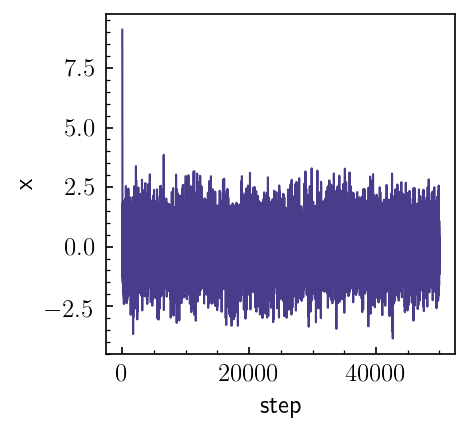

In [18]:
from codes.plot_utils import plot_line_points
istep = np.arange(np.size(chain1))

plot_line_points(istep, chain1, xlabel='step', ylabel='x', figsize=3)

In [8]:
def plot_1d_pdf_mcmc(xchain, *args, iterlim=100, xlims=[-5.,5.], ylims=[1.e-3,1.], 
                     modelpdf=None, pacc=None, step=None, nbins=200,  lw=1, filename=None):
    """
    plot 1d distribution of a chain produced by MCMC along with its trace
    
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
    ax[0].set_xlabel(r'$x$'); ax[0].set_ylabel(r'$p(x)$')
    ax[0].set_yscale('log')
    hist, bins, patches = ax[0].hist(xchain, density=True,
                                     bins=nbins, color='slateblue',
                                     label=r'$p_{\rm acc}=%.2f;\ s=%.1f$'%(pacc,step))
    binc = 0.5*(bins[1:] + bins[:-1]) # compute bin centers
    y = np.zeros_like(binc)
    for i, bincd in enumerate(binc):
        y[i] = modelpdf(bincd, *args)
        
    #normalize Gaussian pdf properly
    #y -= 0.5*(np.log(2.*np.pi) + np.log(1./args[1]))
    
    y = np.exp(y)
    ax[0].plot(binc, y, lw=lw, color='r')
    ax[0].legend(fontsize=7, loc='upper right', frameon=False)
    ax[1].yaxis.set_label_position('right')
    ax[1].set_xlabel(r'$\rm MCMC\ step$'); ax[1].set_ylabel(r'$x$')
    ax[1].set_xlim(0., iterlim); #ax[0].set_ylim(-2.2,2.2)
    ax[1].plot(xchain, lw=0.5)
    if filename is not None:
        plt.savefig('fig/'+filename, bbox_inches='tight')
    plt.show()
    

In [9]:
print(np.size(np.unique(np.array(chain10))))
print(np.size(chain10))

7912
50001


The left plot compares the distribution of MCMC samples (histogram) to the target Gaussian pdf (red line). The right plot shows values of sample $x$ as a function of MCMC step (i.e. order of the sample in the MCMC sequence). The right plot is called *"trace"* in the MCMC jargon. 

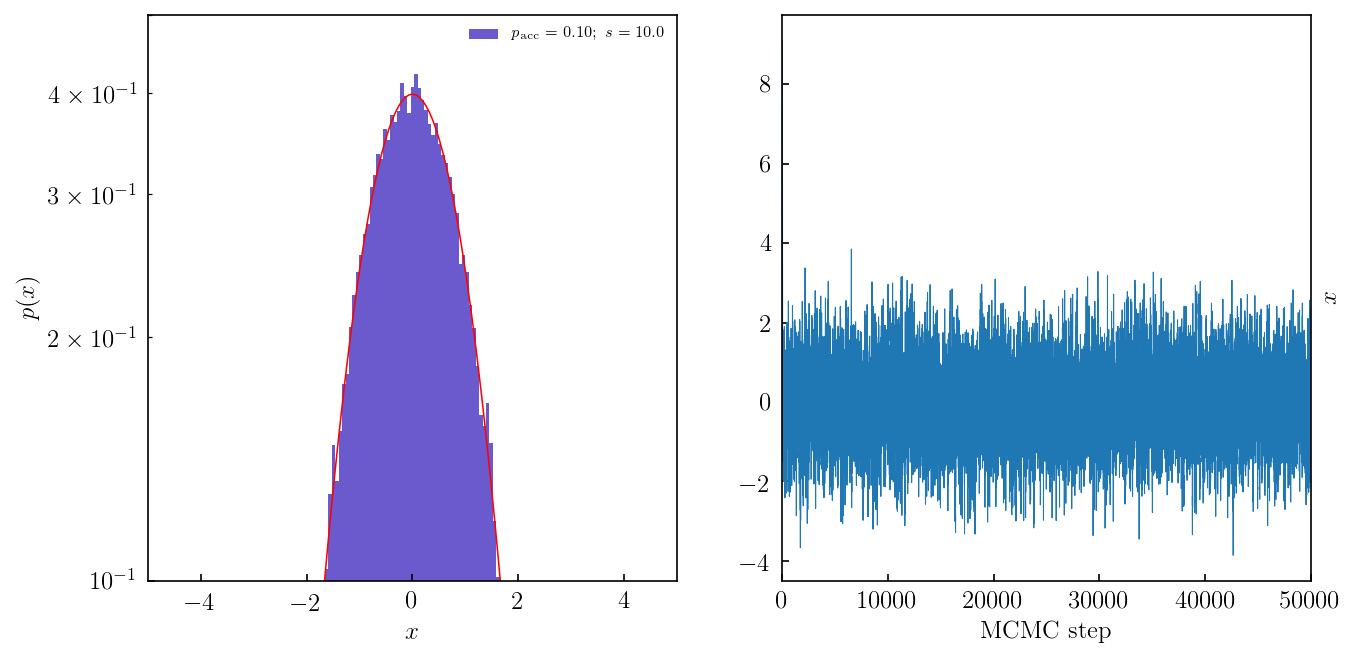

In [20]:
plot_1d_pdf_mcmc(chain1, *args, modelpdf=lngauss1d, iterlim=50000, ylims=[1.e-1,0.5],  pacc=0.1, step=step, lw=0.75)

### The number of independent MCMC samples in the chain

Even for a well-converged chain with well chosen step size, not all of the samples are independent. Even though the chain is "Markovian" - i.e. next step depends only on the current location of the sample - the chain retains memory of its past trajectory over some number of steps. 

For example, starting at $x_0=10$ in the example, above, it will take some number of steps for $x$ to reach the high probability area around $x=0$. Over this number of steps, there is memory that we started at $x_0=10$. 

The number of steps, for which this memory is typically retained, can be measured by the *auto-correlation time,* which is the number of steps over which auto-correlation function of the chain has large amplitude. The autocorrelation function is defined below and routines computing it are provided.  

### Auto-correlation function

For discrete data evaluated at evenly spaced points auto-correlation function is defined as 

$$ 
\xi(j) = \frac{\sum\limits_{i=0}^{N-j-1}\left[(x_i-\bar{x})(x_{i+j}-\bar{x})\right]}{\sum\limits_{i=0}^{N-1}(x_i-\bar{x})^2}.
$$

where $\bar{x}$ is the mean over some large portion of the sequence (say up to <tt>lagmax</tt> parameter in the implementation below). 

In [21]:
def auto_corr_func(timeseries, lagmax):
    """
    compute auto correlation function
    """
    ts = np.asarray(timeseries)
    N = np.size(ts) - 1
    ts -= np.average(ts) # Set to mean 0
    corr_func = np.zeros(lagmax)
    for dt in range(lagmax):
        # sum of ts[t+dt]*ts[t]
        corr_func[dt] = (np.dot(timeseries[0:N-dt],timeseries[dt:N])) 
    if (corr_func[0]>0):
        corr_func /= corr_func[0] # normalize
    return corr_func

def compute_tcorr(timeseries,maxcorr):
    """
    compute correlation time
    """
    timeseries = np.copy(timeseries)
    mean = np.average(timeseries)
    corrfxn = auto_corr_func(timeseries,maxcorr)
    tau = np.sum(corrfxn)-1
    var = np.var(timeseries)
    sigma = np.sqrt(var * tau / len(timeseries))
    return tau, mean, sigma


In [22]:
maxlag = 1000
tcorr01, mean, sig = compute_tcorr(chain01,maxlag)
tcorr1, mean, sig  = compute_tcorr(chain1,maxlag)
tcorr10, mean, sig = compute_tcorr(chain10,maxlag)
print("s=0.1: auto-correlation time %.3g"%tcorr01)
print("s=1: auto-correlation time %.3g"%tcorr1)
print("s=10: auto-correlation time %.3g"%tcorr10)

s=0.1: auto-correlation time 553
s=1: auto-correlation time 9.11
s=10: auto-correlation time 6.24


The auto-correlation times measured for these sequences mean that only every $\approx 550$th sample in the chain constructed with $s=0.1$ is independent. For $s=1$ only every $\approx 10$th sample is really independent. 

The fractional error of Monte Carlo estimates of various quantities scales as $\propto 1/\sqrt{N_{\rm samples}}$ (see, for example, example of Monte Carlo integration in  <a href="06b_monte_carlo_methods.ipynb"><tt>06b_monte_carlo_methods.ipynb</tt></a> notebook). The effective number of samples in the MCMC chain is $N_{\rm samples}\approx N_{\rm MCMC}/t_{\rm corr}$, where $N_{\rm MCMC}$ is the length of the chain and $t_{\rm corr}$ is its auto-correlation time. 

Large auto-correlation time thus makes effective number of samples small and accuracy of the MCMC estimates based on the chain poor. 

Thus, to understand how well we sample the distribution we need to estimate $t_{\rm corr}$ and $N_{\rm samples}=N_{\rm MCMC}/t_{\rm corr}$. For $s=0.1$ case above, $N_{\rm samples}\approx 50000/500\approx 100$ - i.e. despite the fact that we constructed chain of 50000 samples, we only have about 100 independent samples. This is why the trace and histogram look so bad. For this step, we'd need to get a 100 times longer chain to get to $N_{\rm samples}\sim 10^4.$. 

Below auto-correlation functions are plotted to get you a sense of what they look like. The auto-correlation time is a characteristic number of steps, by which the ACF falls by a factor of $e$. 

In [77]:
def plot_corr_func3(corr_func01, corr_func1, corr_func10, tcorr01, tcorr1, tcorr10, tlims=[0,100], filename=None):
    fontsize = 15
    tcf01 = np.arange(np.size(corr_func01))
    tcf1 = np.arange(np.size(corr_func1))
    tcf10 = np.arange(np.size(corr_func10))
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].set_xlim(tlims); ax[0].set_ylim(1.e-3,2.)
    ax[0].set_xlabel(r'$t$'); ax[0].set_ylabel(r'$\vert\xi_{tt}(t)\vert$')
    ax[0].set_yscale('log')
    td = np.linspace(tlims[0], tlims[1], 100)
    cfexp = np.exp(-td/tcorr01)
    ax[0].plot(td, cfexp, '--', lw=2., color='violet', label=r'$e^{-\frac{t}{\tau}};\ \ \tau=%.2e$'%tcorr01)
    ax[0].plot(td, cfexp, '--', lw=1., color='lavender')
    ax[0].plot(tcf01, np.abs(corr_func01), lw=1., color='slateblue', label=r'$s=0.1$')
    ax[0].legend(fontsize=fontsize, loc='lower left', frameon=False)
    
    tlims = [0,50]
    ax[1].set_xlim(tlims); ax[1].set_ylim(1.e-3,2.)
    ax[1].set_xlabel(r'$t$'); #ax[0].set_ylabel(r'$\vert\rho_{xx}(t)\vert$')
    ax[1].set_yscale('log')
    td = np.linspace(tlims[0], tlims[1], 100)
    cfexp = np.exp(-td/tcorr1)
    ax[1].plot(td, cfexp, '--', lw=2., color='violet', label=r'$e^{-\frac{t}{\tau}};\ \ \tau=%.2e$'%tcorr1)
    ax[1].plot(td, cfexp, '--', lw=1., color='lavender')
    ax[1].plot(tcf1, np.abs(corr_func1), lw=1., color='slateblue', label=r'$s=1$')
    ax[1].legend(fontsize=fontsize, loc='lower left', frameon=False)
    
    tlims = [0,20]
    ax[2].set_xlim(tlims); ax[2].set_ylim(1.e-3,2.)
    ax[2].set_xlabel(r'$t$'); #ax[0].set_ylabel(r'$\vert\rho_{xx}(t)\vert$')
    ax[2].set_yscale('log')
    td = np.linspace(tlims[0], tlims[1], 100)
    cfexp = np.exp(-td/tcorr10)
    ax[2].plot(td, cfexp, '--', lw=2., color='violet', label=r'$e^{-\frac{t}{\tau}};\ \ \tau=%.2e$'%tcorr10)
    ax[2].plot(td, cfexp, '--', lw=1., color='lavender')
    ax[2].plot(tcf10, np.abs(corr_func10), lw=1., color='slateblue', label=r'$s=10$')
    ax[2].legend(fontsize=fontsize, loc='lower left', frameon=False)

    if filename is not None:
        plt.savefig('fig/'+filename, bbox_inches='tight')
    plt.show()


In [78]:
lagmax = 5000
cf01 = auto_corr_func(chain01, lagmax)
cf1 = auto_corr_func(chain1, lagmax)
cf10 = auto_corr_func(chain10, lagmax)

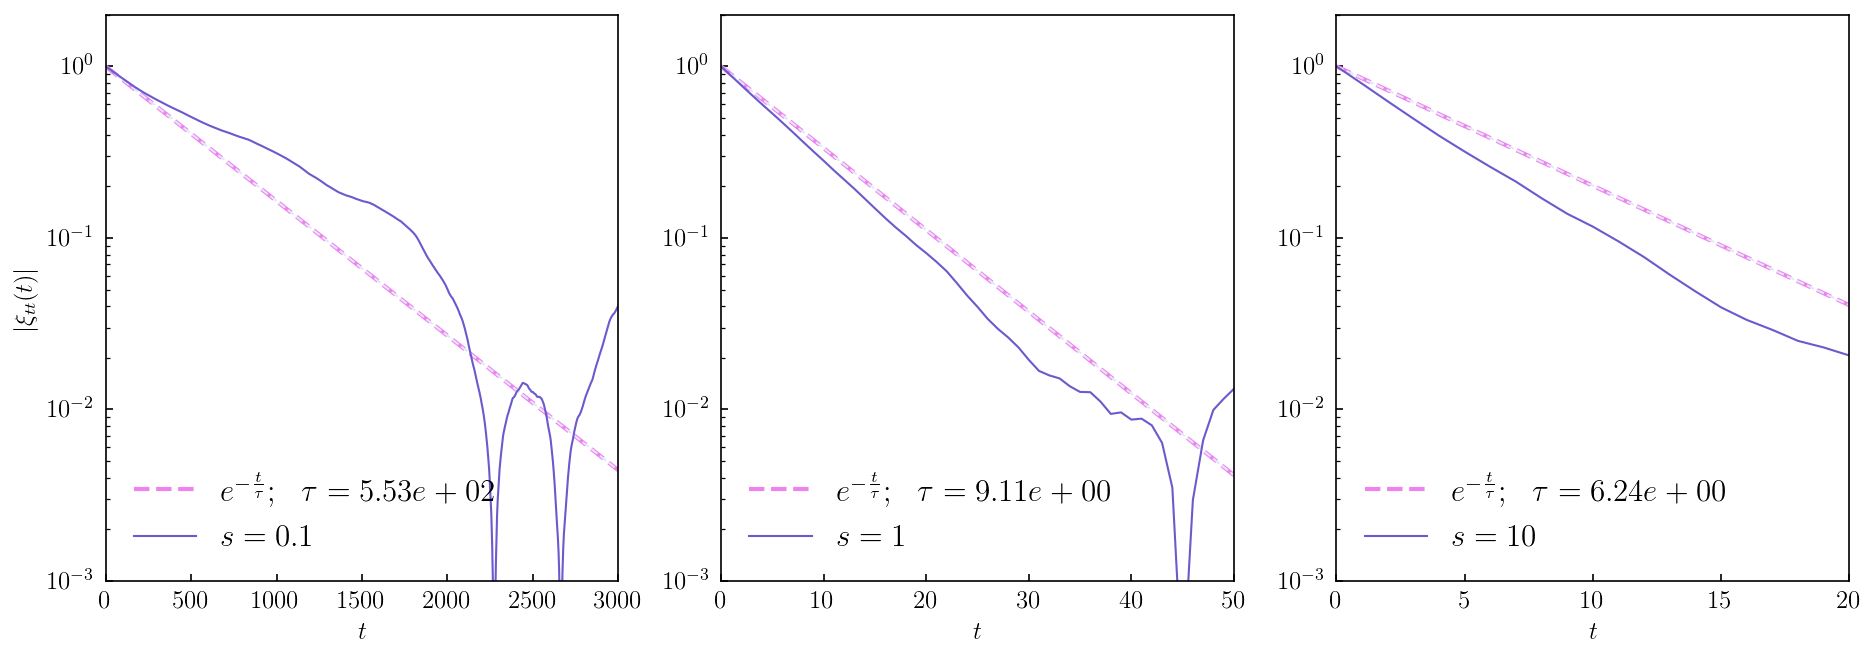

In [79]:
plot_corr_func3(cf01, cf1, cf10, tcorr01, tcorr1, tcorr10, tlims=[0,3000], filename=None)

### Multivariate (multi-dimensional) Gaussian distribution

A $d$-dimensional Gaussian distribution is <a href="https://en.wikipedia.org/wiki/Multivariate_normal_distribution">defined as</a> 

$$p_{\rm G}(x_1,\ldots,x_d) =\frac{1}{\sqrt{(2\pi)^k\vert\Sigma\vert}}\,\exp\left[-\frac{1}{2}(\vec{x}-\vec{\mu})^T\mathbf{\Sigma}^{-1}(\vec{x}-\vec{\mu})\right],$$

where $\vec{\mu}$ is a vector of mean values in  $\Sigma$ is covariance matrix ($\vert\Sigma\vert$ is its determinant). 

We will work with  $\ln$ of this distribution:
$$\ln p_{\rm G}(x_1,\ldots,x_d) = -\frac{1}{2}(\vec{x}-\vec{\mu})^T\mathbf{\Sigma}^{-1}(\vec{x}-\vec{\mu}) -\frac{k}{2}\ln 2\pi - \frac{1}{2}\ln\vert\Sigma\vert.$$

The last two normalization terms can be dropped in the MCMC sampling because they don't depend on $\vec{x}$.  

We will start by sampling a 1d Gaussian to have an easy way to visualize and illustrate the main aspects and issues of the MCMC method. We will then consider sampling some 2d distributions with a routine and <tt>emcee</tt> package that can work in any number of dimensions. 

In [25]:
def gauss_nd(x, means, icov):
    """
    ln of N-dimensional unnormalized Gaussian pdf
    
    Parameters:
    -----------
    x - real 1d numpy vector of size ndim
        position of a sample in ndim-dimensional space
    means - real 1d numpy vector of size ndim
        mean values of the Gaussian in each coordinate
    icov - real numpy array of size [ndim x ndim]
        inverse covariance matrix of the Gaussian
        
    Returns:
    --------
    
    a real number 
        ln(Gaussian)
    """
    diff = x - means
    lpf = - 0.5*np.dot(diff , np.dot( icov , diff ) ) 
    
    return lpf

### Sampling a 2d Gaussian

Now let's sample a 2-dimensional Gaussian. If the Gaussian is characterized by the mean value in two variables, $\vec{\mu}=[\mu_{x_1},\mu_{x_2}]$, rms values, $\sigma_{x_1}$, $\sigma_{x_2}$ and correlation coefficient, $\rho$. The covariance matrix is: 

$$
\mathbf{\Sigma}=\left(
  \begin{array}{cc}
   \sigma^2_{x_1} & \rho\sigma_{x_1}\sigma_{x_2} \\
     \rho\sigma_{x_1}\sigma_{x_2} & \sigma^2_{x_2}  \\
  \end{array} \right)
$$

Let's specify a Gaussian with zero means, unit variances in the two dimensions and a given correlation coefficient. Try to run this with $\rho=0.95, 0.99, 0.999$ and check how distribution of resulting samples look like and how the acceptance ratio changes with $\rho$. 

In [26]:
s1, s2, r = 1.0, 1.0, 0.95

means = [0., 0.]
cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]

# compute the inverse covariance matrix
icov = np.linalg.inv(cov)

ndim = 2
nsteps = 100000
x0 = np.random.rand(ndim)
step = 1.

args=[means,icov]
xchain1 = simple_mcmc(x0, nsteps, step, gauss_nd, *args)

finished 100000 steps with acceptance ratio = 0.3724


C:\Users\h2_sf\AppData\Roaming\Python\Python37\site-packages\scipy\signal\signaltools.py:974: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\h2_sf\AppData\Roaming\Python\Python37\site-packages\scipy\signal\signaltools.py:974: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
C:\Users\h2_sf\Documents\Classes\a211w20\a211w20\codes\plot_utils.py:162: UserWarning: Log scale: values of z <= 0 have been masked
  norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])


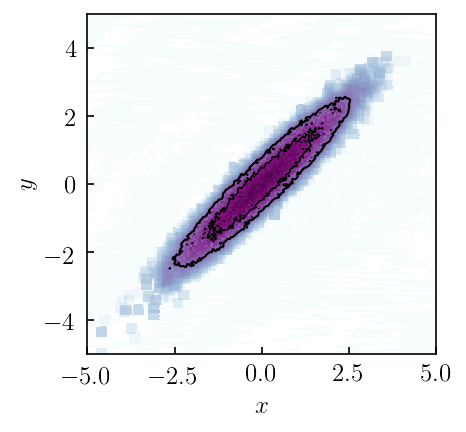

In [27]:
from codes.plot_utils import plot_2d_dist

xchain1 = np.array(xchain1)
x1 = xchain1[:,0]; x2 = xchain1[:,1]

conflevs = [0.6827, 0.9545]

plot_2d_dist(x1, x2, xlim=[-5,5], ylim =[-5,5], nxbins=200, nybins=200, 
             clevs=conflevs, smooth=6, xlabel='$x$', ylabel='$y$', figsize=(3,3))

### Parameter constraints and likelihood sampling using MCMC 

"Fitting" a linear model:

$$y\sim mx + c +\varepsilon$$

where $\varepsilon$ is a Gaussian uncertainty of $y$ measurement. 

In [69]:
# construct a "mock" data following linear model with Gaussian perturbations
m = 2.; c=0.

ndata = 30

xmin, xmax = -10., 10.
# randomly located x values
xd = np.random.uniform(xmin, xmax, size=ndata)
# y depends on x linearly with slope m and intercept c, 
# but is subject to Gaussian fluctuations due to measurement uncertainites
sigy = np.random.normal(scale=2., size=ndata)
yd = m*xd + c + sigy


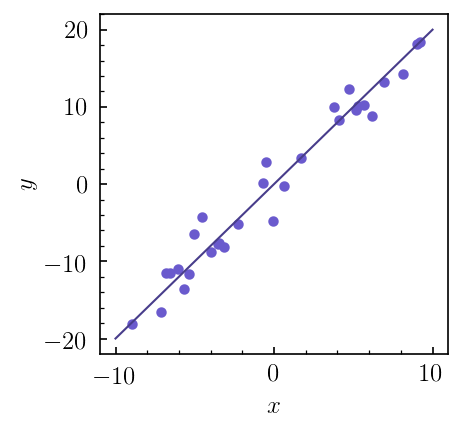

In [74]:
# plot generative linear model and mock data realization

nt = 100
xt = np.linspace(xmin, xmax, nt)
yt = m*xt + c
plot_line_points(xt, yt, points=True, xp=xd, yp=yd, xlabel=r'$x$', ylabel=r'$y$', figsize=3)

### Likelihood for linear model 

Probability distribution to have the data represented by vectors $\vec{x}, \vec{y}, \vec{\sigma}_{y}$ (of length $N_{\rm data}$ each) given the linear model with slope and intercept $m$ and $c$: 
$$L(\vec{x}, \vec{y}, \vec{\sigma}_{y}\vert c, m) = \prod\limits_{i=0}^{N_{\rm data}-1}\frac{1}{\sqrt{2\pi\sigma^2_{y,i}}}\,\exp\left[-\frac{1}{2}\left(\frac{y_i-mx_i -c}{\sigma_{y,i}}\right)^2\right]$$

Natural log of this likelihood is then 

$$\ln L(\vec{x}, \vec{y}, \vec{\sigma}_{y}\vert c, m) = -\frac{1}{2}\sum\limits_{i=0}^{N_{\rm data}-1}\left[\ln\left(2\pi\sigma^2_{y,i}\right)+ \left(\frac{y_i-mx_i -c}{\sigma_{y,i}}\right)^2\right]$$

which is implemented below. The factor of $\ln(2\pi)$ is often dropped, because it is just a constant (i.e. normalization of the pdf). MCMC is not sensitive to the normalization of the pdf that is sampled and this factor is often dropped for this reason. 

In [47]:
def linmodel_likelihood(p, *args):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    x - real 1d numpy vector
        x values of data, array size = number of data points ndata
    sigx2 - real 1d numpy vector of size x
        Gaussian variances of x
    y - real 1d numpy vector
        y values of data of the same size as x 
    sigy2 - real 1d numpy vector of size 
        Gaussian variances of y
    sigxy - real 1d numpy vector of size 
        Gaussian covariances of x and y    

    Returns:
    --------

    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    x = args[0]; y = args[1]; sigy = args[2]
    sigtot2 = sigy**2 
    # this step is not to allow sigtot2 to become negative which will make np.log of it below a nan (Not A Number)
    sigtot2 = np.maximum(sigtot2, 1.6e-16)
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))


In [71]:
ndim = 2
nsteps = 100000
x0 = [-1., 1.]
step = 0.01

args = [xd, yd, sigy]
xchain1 = simple_mcmc(x0, nsteps, step, linmodel_likelihood, *args)


finished 100000 steps with acceptance ratio = 0.2981


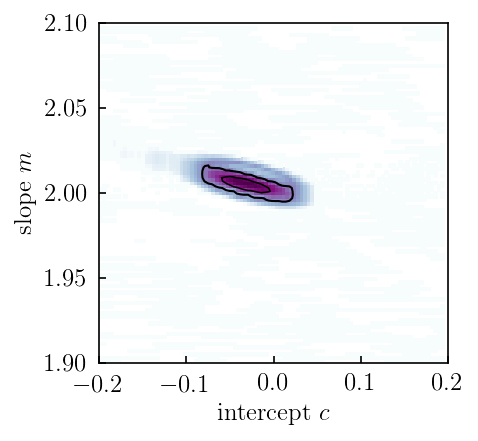

In [73]:
from codes.plot_utils import plot_2d_dist

xchain1 = np.array(xchain1)
x1 = xchain1[:,0]; x2 = xchain1[:,1]

conflevs = [0.6827, 0.9545]

plot_2d_dist(x1, x2, xlim=[-0.2,0.2], ylim =[1.9,2.1], 
             nxbins=100, nybins=100, 
             clevs=conflevs, smooth=6, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ m$', figsize=(3,3))

This gives you an idea of how parameters are sampled with MCMC. It's generally better to use a more efficient MCMC method, which is not sensitive to step size, such as the affine-invariant method of Goodman & Weare that is described below. This method is implemented in the publicly available <a href="https://emcee.readthedocs.io/en/stable/"><tt>emcee</tt></a> package. 

### The MCMC algorithm seems great. What's the catch?

The algorithm is simple and it works. Why would one want to learn about any other method (like inverse transform and rejection sampling)?


As you may have guessed. There is a catch, or rather a number of catches. These have the following names: "burn-in", "acceptance ratio" and "correlation length", "convergence" and "stopping criteria." 


We will discuss these in turn, but the issue with all of them is that there are no firm criteria and guidelines for dealing with them. Proper application of MCMC requires care, some amount of "black art" (aka experience and intuition). One should also be on the lookout for spurious results.

None of these issues are a show-stopper, however. The method is powerful, albeit often not very efficient, and is the only game in town in many dimensions. 

### Burn-in 

Declaring the first MCMC sample to be a real sample of a distribution, may seem like cheating and it is, in a way. However, there is a price to pay. 

You can declare $x=10$ to be a sample of $e^{-x^2/2}$, but it is a highly improbable sample. This will make some number of subsequent samples derived from it improbable as well. In practice, this necessitates defining a *"burn-in"* sequence of improbable samples and removing it from the final sample of draws. 

Criteria for defining "burn-in sequence" are fuzzy, however. The recommended heuristic rule is to exclude at least the first $20\tau$ steps in the sequence, where $\tau$ is the auto-correlation "time" (or rather step number) defined and illustrated above. This means that for the chain for step size of $0.1$, we would need to remove the first $\approx 16000$ samples. 

### A faster (?), vectorized implementation of the MCMC sampler

The simple implementation above produces a single MCMC chain. However, we can initialize a number of such chains and follow them in parallel, while dealing with a set of chains using numpy vector operations.

A version below implements this idea.

In [80]:
def vectorized_mcmc(x, nsteps=1, step=0.1, modelpdf = None, args = None):
    """
    MCMC sampler implementing a simple Metropolis algorithm
    to follow a number of chains ("walkers") in parallel
    
    This version also can sample distributions of arbitrary number of 
    dimensions ndim
    
    Parameters:
    ------------
    x0 - a real numpy array of size [nwalkers,ndim]
        initial x value
    nsteps - integer
        number of MCMC steps (iterations) to take
    step - float
        step size controlling step proposal distribution
    modelpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args - pointer to a list
        list of arguments to pass modelpdf
        
    Returns:
    ---------
    xchain - numpy array of size [nsteps*nwalkers, ndim]
        coordinates of samples in the MCMC chains of size
    pacc   - float
        acceptance ratio of the MCMC steps (ratio of accepted to the total proposed number of steps)
    
    """
    
    # the input array here contains initial values for multiple MCMC sequences
    # or "walkers" in the MCMC jargon (because they "walk" the multi-d space of our target pdf)
    nwalkers = np.shape(x)[0]
    # make sure input is sensible
    assert(nwalkers>0)
    
    # number of dimensions that we will be sampling
    ndim = np.shape(x)[1]
        
    # initialize some auxiliary arrays and variables 
    chain = x;

    naccept = 0; ntry = 0; nchain = 0
    # initialize arrays that will be used to hold pdf values of samples
    # at old and proposed sample locations
    gxold = np.empty(nwalkers)
    gxtry = np.empty(nwalkers)
    for i in range(nwalkers):
        gxold[i] = modelpdf(x[i,:], *args)
    eps = 2.e-16
    
    nsample = 0 
    while nsample < nsteps:
        # proposal step using uniform pdf in range [-step, step]
        xtry  = x + step*np.random.uniform(-step, step, np.shape(x)) 
        for i in range(nwalkers):
            gxtry[i] = modelpdf(xtry[i,:], *args) 
        gx = np.copy(gxold) 
        # compare pdf values at the old and proposed sample locations  
        gr   = gxtry - gx
        u = np.random.uniform(eps,1.0,np.shape(x)[0])
        # accept proposal with probability min[1.0, e^gr]
        iacc = np.where(gr > np.log(u))
        # update those "walkers" for which proposal step was accepted 
        x[iacc,:] = xtry[iacc,:]
        gxold[iacc] = gxtry[iacc]
        naccept += np.size(gxtry[iacc])
        # add all walkers to the chain, regardless of whether their proposal step was accepted
        chain = np.vstack((chain, x))
        nsample += 1

    return chain, 1.*naccept/(nsample*nwalkers)

In [81]:
from timeit import default_timer

args = [0., 1.]

ndim = 1
nwalkers = 1000
nsteps = 100
step = 1.

# initialize walkers in a uniform random distribution
x0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

tstart = default_timer()
xchain1, pacc1 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = gauss_nd, args=args)
tend = default_timer()

print("elapsed time = %.3g sec, acceptance ratio=%.3g"%(tend-tstart, pacc1))

elapsed time = 0.349 sec, acceptance ratio=0.807


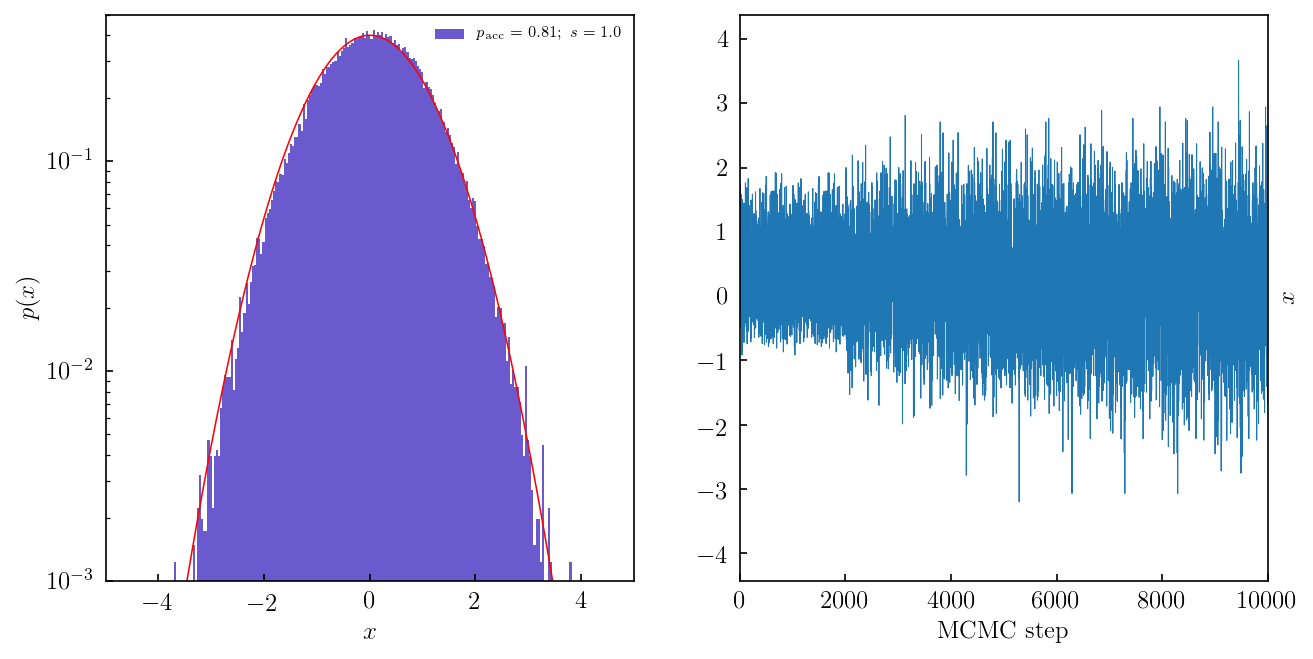

In [86]:
nburn = 1

plot_1d_pdf_mcmc(xchain1[nburn:], *args, iterlim=10000, ylims=[1.e-3,0.5], 
                 modelpdf=lngauss1d, pacc=pacc1, step=step, lw=0.75)

In [87]:
s1, s2, r = 1.0, 1.0, 0.95

means = [0., 0.]
cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]

# compute the inverse covariance matrix
icov = np.linalg.inv(cov)

nwalkers = 100
ndim = 2
nsteps = 1000
x0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
step = 1.

tstart = default_timer()

xchain1, pacc1 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = gauss_nd, args=[means,icov])

tend = default_timer()
print("elapsed time = %.3g sec, acceptance ratio=%.3g"%(tend-tstart, pacc1))

elapsed time = 0.838 sec, acceptance ratio=0.369


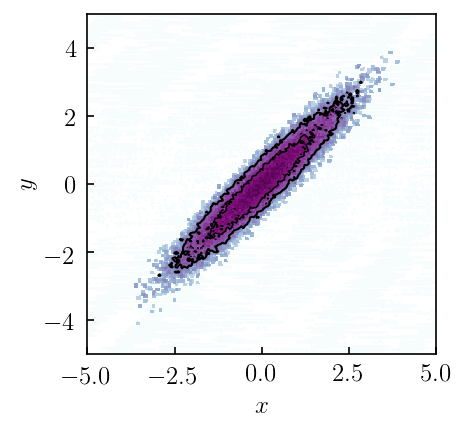

In [88]:
from codes.plot_utils import plot_2d_dist

x1 = xchain1[:,0]; x2 = xchain1[:,1]

conflevs = [0.6827, 0.9545]

plot_2d_dist(x1, x2, xlim=[-5,5], ylim =[-5,5], nxbins=200, nybins=200, 
             clevs=conflevs, smooth=2, xlabel='$x$', ylabel='$y$', figsize=(3,3))

### Comparing to emcee MCMC package

Let's compare our result to the most popular MCMC package in astronomy <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a>. 

To install it, do

    pip install emcee
    
in the Anaconda command prompt or linux/MacOS shell.

In [89]:
import emcee

ndim, nwalkers, nsteps = 2, 100, 1000

p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

tstart = default_timer()

sampler = emcee.EnsembleSampler(nwalkers, ndim, gauss_nd, args=[means,icov])

echain, prob, state = sampler.run_mcmc(p0, nsteps)

tend = default_timer()

# acceptance fraction averaged over all walkers
eacc = np.mean(sampler.acceptance_fraction)
print("emcee time = %.3g sec, acceptance fraction = %.3g"%(tend-tstart, eacc))

emcee time = 0.682 sec, acceptance fraction = 0.715


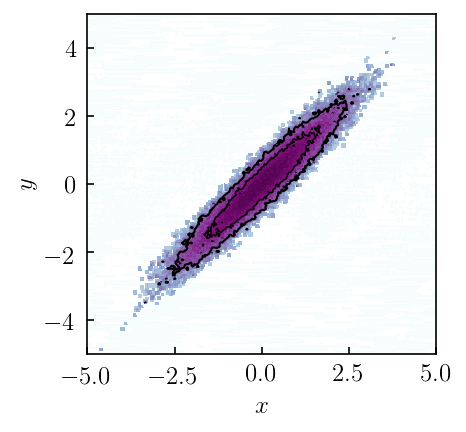

In [90]:
x1 = sampler.flatchain[:,0]; 
x2 = sampler.flatchain[:,1]

plot_2d_dist(x1, x2, xlim=[-5,5], ylim =[-5,5], nxbins=200, nybins=200, 
             clevs=conflevs, smooth=2, xlabel='$x$', ylabel='$y$', figsize=(3,3))

### Sampling a much more difficult distribution

What follows below is a distribution I called "smiley face" (although some find the name "alien face" more appropriate, given how it appears in some renderings): it consists of two 2-d Gaussians and a Rosenbrock "banana" distribution.


In [47]:
def smiley_face_pdf(xin, *args):
    x = xin[0]; y = xin[1]
    fa1, fx1, fy1, fsx1, fsy1, fr1, fa2, fx2, fy2, fsx2, fsy2, fr2 = args
    # Gaussian pdfs 1 and 2
    res  = (np.clip(fa1*np.exp(-0.5/(1 - fr1**2)*( ((x-fx1)/fsx1)**2 +
                    ((y-fy1)/fsy1)**2 + 2*fr1*(x-fx1)*(y-fy1)/(fsx1*fsy1) )),
                    1.e-300, 1.e300))
    res += (np.clip(fa2*np.exp(-0.5/(1 - fr2**2)*( ((x-fx2)/fsx2)**2 +
                    ((y-fy2)/fsy2)**2 + 2*fr2*(x-fx2)*(y-fy2)/(fsx2*fsy2) )),
                    1.e-300, 1.e300))
    # + Rosenbrock pdf
    res += np.clip(np.exp(-(100.*(y-x**2)**2 + (4.0-x)**2)/20.0), 1.e-300, 1.e300)
    return np.log(np.clip(res, 1.e-300, 1.e300))

In [48]:
fa1 = 0.1; fx1 =  4.0; fy1 =  80.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
fa2 = 0.1; fx2 =  -4.0; fy2 =  80.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8

args = [fa1, fx1, fy1, fsx1, fsy1, fr1, fa2, fx2, fy2, fsx2, fsy2, fr2]

In [50]:
nwalkers = 100
ndim = 2
nsteps = 1000

#uniformly distributed walkers in ndim with locations from 0 to 1
x0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
step = 1.

tstart = default_timer()

xchain1, pacc1 = vectorized_mcmc(x0, nsteps=nsteps, step=step, 
                                 modelpdf = smiley_face_pdf, args=args)

tend = default_timer()
print("elapsed time = %.3g sec, acceptance ratio=%.3g"%(tend-tstart, pacc1))

elapsed time = 1.96 sec, acceptance ratio=0.246


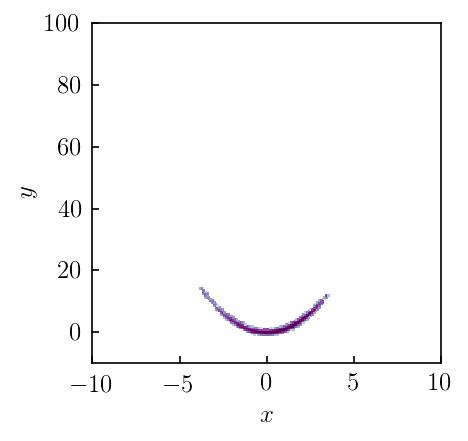

In [52]:
x1 = xchain1[:,0]; x2 = xchain1[:,1]
plot_2d_dist(x1, x2, xlim=[-10,10], ylim =[-10,100], nxbins=200, nybins=200, 
             clevs=None, xlabel='$x$', ylabel='$y$', figsize=(3,3))

Now with emcee

In [54]:
ndim, nwalkers, nsteps = 2, 100, 1000

p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, smiley_face_pdf, args=args)

echain, prob, state = sampler.run_mcmc(p0, nsteps)


# acceptance fraction averaged over all walkers
eacc = np.mean(sampler.acceptance_fraction)
print("emcee time = %.3g sec, acceptance fraction = %.3g"%(tend-tstart, eacc))

emcee time = 1.96 sec, acceptance fraction = 0.348


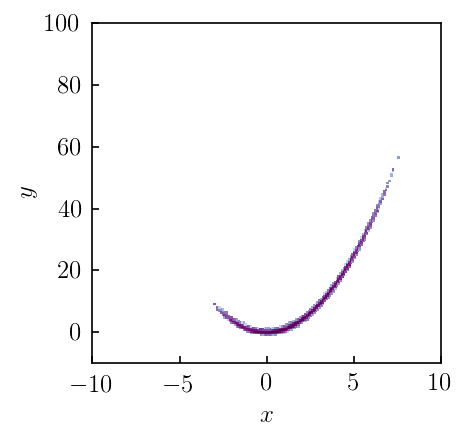

In [56]:
x1 = sampler.flatchain[:,0]; 
x2 = sampler.flatchain[:,1]

plot_2d_dist(x1, x2, xlim=[-10,10], ylim =[-10,100], nxbins=200, nybins=200, 
             clevs=None, xlabel='$x$', ylabel='$y$', figsize=(3,3))

The above looks more like a "smirk" than a smile. This is because the Rosenbrock "banana" pdf is assymetric. We can see that emcee sampled the tail of the distribution much better than our implementation of the Metropolis algorithm and with a much larger acceptance ratio. 

But where are the Gaussian "eyes" in the smiley face? How should this distribution look like?

In [61]:
from matplotlib.colors import LogNorm

def plot_2d_pdf(modelpdf, xlims, ylims, nxbins=200, nybins=200, args=args, figsize=(3,3)):
    xbins = np.linspace(xlims[0], xlims[1], nxbins)
    ybins = np.linspace(ylims[0], ylims[1], nybins)
    X, Y = np.meshgrid(xbins,ybins) 

    smf = modelpdf([X,Y], *args)

    fig, ax = plt.subplots(figsize=figsize)
    plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.xlim(xlims); plt.ylim(ylims)

    pcol = ax.pcolormesh(X, Y, np.exp(smf), cmap='Blues', norm = LogNorm(), linewidth=0., rasterized=True)

    plt.show()
    

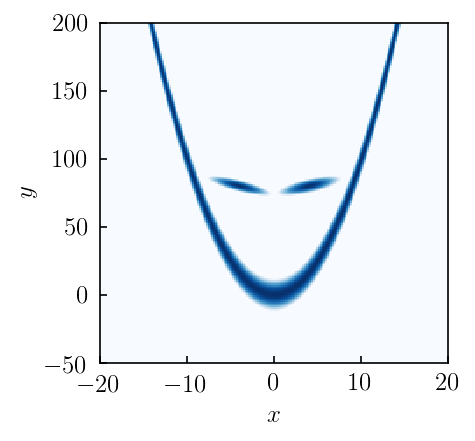

In [62]:
nxbins, nybins = 200, 200;
xlims = [-20, 20]; ylims = [-50, 200]

plot_2d_pdf(smiley_face_pdf, xlims, ylims, nxbins=nybins, nybins=nxbins, args=args, figsize=(3,3))

Let's try again with a more widspread initial distribution of walkers and 10 times larger number of walkers.

In [64]:
nwalkers = 1000

p0 = 100.*np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, smiley_face_pdf, args=args)

echain, prob, state = sampler.run_mcmc(p0, nsteps)

# acceptance fraction averaged over all walkers
eacc = np.mean(sampler.acceptance_fraction)
print("emcee time = %.3g sec, acceptance fraction = %.3g"%(tend-tstart, eacc))

C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


emcee time = 1.96 sec, acceptance fraction = 0.79


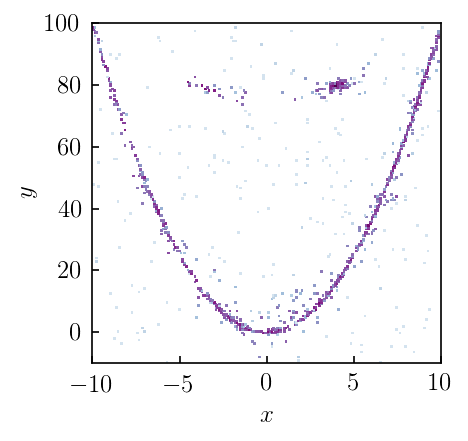

In [66]:
x1 = sampler.flatchain[:,0]; 
x2 = sampler.flatchain[:,1]

plot_2d_dist(x1, x2, xlim=[-10,10], ylim =[-10,100], nxbins=200, nybins=200, 
             clevs=None, xlabel='$x$', ylabel='$y$', figsize=(3,3))

This looks much better, but is still quite far from the fully sampled distribution shown above. So how do we know how many walkers and how many steps to use in order to get fully sampled (converged) distribution? 

In [ ]:
def vectorized_mcmc(x, nsteps=1, step=0.1, modelpdf = None, args = None):
    """
    MCMC sampler implementing a simple Metropolis algorithm
    to follow a number of chains ("walkers") in parallel
    
    This version also can sample distributions of arbitrary number of 
    dimensions ndim
    
    Parameters:
    ------------
    x0 - a real numpy array of size [nwalkers,ndim]
        initial x value
    nsteps - integer
        number of MCMC steps (iterations) to take
    step - float
        step size controlling step proposal distribution
    modelpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args - pointer to a list
        list of arguments to pass modelpdf
        
    Returns:
    ---------
    xchain - numpy array of size [nsteps*nwalkers, ndim]
        coordinates of samples in the MCMC chains of size
    pacc   - float
        acceptance ratio of the MCMC steps (ratio of accepted to the total proposed number of steps)
    
    """
    
    # the input array here contains initial values for multiple MCMC sequences
    # or "walkers" in the MCMC jargon (because they "walk" the multi-d space of our target pdf)
    nwalkers = np.shape(x)[0]
    # make sure input is sensible
    assert(nwalkers>0)
    
    # number of dimensions that we will be sampling
    ndim = np.shape(x)[1]
        
    # initialize some auxiliary arrays and variables 
    chain = np.empty_like(x);

    naccept = 0; ntry = 0; nchain = 0
    # initialize arrays that will be used to hold pdf values of samples
    # at old and proposed sample locations
    gxold = np.empty(nwalkers)
    gxtry = np.empty(nwalkers)
    for i in range(nwalkers):
        gxold[i] = modelpdf(x[i,:], *args)
    
    nsample = 0 
    while nsample < nsteps:
        # proposal step using uniform pdf in range [-step, step]
        xtry  = x + step*np.random.uniform(-step, step, np.shape(x)) 
        for i in range(nwalkers):
            gxtry[i] = modelpdf(xtry[i,:], *args) 
        gx = np.copy(gxold) 
        # compare pdf values at the old and proposed sample locations  
        gr   = gxtry - gx
        u = np.random.uniform(0.0,1.0,np.shape(x)[0])
        # accept proposal with probability min[1.0, e^gr]
        iacc = np.where(gr > np.log(u)) 
        # update those "walkers" for which proposal step was accepted 
        x[iacc,:] = xtry[iacc,:]
        gxold[iacc] = gxtry[iacc]
        naccept += np.size(gxtry[iacc])
        # add all walkers to the chain, regardless of whether their proposal step was accepted
        chain = np.vstack((chain, x))

        nsample += 1
        

    return chain, 1.*naccept/(nsample*nwalkers)

### MCMC convergence

The answer to this question is also "fuzzy" in the MCMC applications, but there are several heuristic *convergence criteria* that are used. That is, chains are increased not for a fixed number of steps, but until a set of convergence criteria are satisfied.

Before we look into that, let's talk about how emcee achieves its better results compared to our implementation. We can gain an insight about why acceptance ratio in the Metropolis MCMC in the cases of very correlated 2d Gaussian distribution or "smiley face" distribution from the following illustrative <a href="http://chi-feng.github.io/mcmc-demo/">visualization of the methods at work</a>.

### Affine-invariant sampler of Goodman & Weare (2010)

<a href="http://msp.org/camcos/2010/5-1/p04.xhtml">Goodman & Weare (2010)</a> have developed a simple MCMC sampling algorithm, which is efficient for distributions that exhibit strong degeneracies (narrow ridges in the pdf), such as the Rosenbrock density pdf discussed above, or pdfs with multiple peaks. 

In this method, one initializes a number of walkers distributed with a multi-variate Gaussian probability around a starting point. Then MCMC chain is constructed in a way similar to the Metropolis algorithm: proposing a step, estimating probability at the proposed location, and then accepting the step with an acceptance probability. The difference from Metropolis is in the way the step is proposed and how acceptance probability is calculated:

* In this method a step from location $\vec{x}_i$ to $\vec{x}_{i+1}$ is proposed as a *stretch* move: $\vec{x}_{i}^{\prime}=\vec{x}_{j}+z_r(\vec{x}_{i}-\vec{x}_j)$, where $\vec{x}_{j}$ is the current location of *another* randomly chosen walker (but not the current one we are updating) and $z_r$ is  a random number drawn from the pdf $g(z)= 1/\sqrt{z}$ for $z\in[1/a,a]$ interval and $g(z)=0$ outside this interval, where GW10 suggest $a=2$. 


* The proposed stretch move is then accepted with probability $p_{\rm acc}={\rm min}[1.0,z_r^{D-1}\pi(\vec{x}_i^{\prime})/\pi(\vec{x})]$, where $\pi$ is the target pdf the chain is supposed to sample and $D$ is the number of components of $\vec{x}$ (i.e., the number of dimensions of the pdf we are sampling; e.g., for the $D=2$ for a 2D Gaussian).  

### Why does GW10 sampling algorithm improve Metropolis MCMC?

discuss

### Recommended reading

* S 3.1-3.8 and S 2 of the <a href="http://adsabs.harvard.edu/abs/2017ARA%26A..55..213S">ARA&A review</a> by Sanjib Sharma on MCMC methods for Bayesian data analysis in astronomy.

* Illustrative <a href="http://chi-feng.github.io/mcmc-demo/">visualizations of MCMC methods at work</a>.